# Convert MongoDB Output to DataFrames

This notebook takes a mongo database configured for pythia experiments and creates pandas dataframes in order to more easily compare experiments.  The first data frame contains all of the variables from the config and results fields in the database.  The second dataframe, if SAVE_RESULTS is flagged in the experiements, creates fields for each observation.  Error rate for each observation is also calculated.  The ability to export each dataframe as csv is also included. 

This notebook also enables ensembling of the results of the experiments.  Two methods are employed:  majority vote and correlation.  Majority vote selects the value that the majority of models predicts.  The correlation ensembler takes a high performing subset of the models and then chooses a subset of those that are not highly correlated with one another.

NOTE:  You are not able to run all cells at once; there are numerous places where user input is required.

In [1]:
import os
import datetime
import json
import numpy as np
import pandas as pd
import pprint
from numpy import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from IPython.display import display, HTML
from pymongo import MongoClient
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
%matplotlib inline

The below code connects to MongoDB by allowing you to enter your host, port, and database.

In [2]:
host = input() #host as string

localhost


In [3]:
port = int(input()) #port as int

27017


In [4]:
# Connect to Mongo host & port

client = MongoClient(host, port)

In [5]:
# Input the name of the database you'd like to connect to. Example 'sacred_demo' or 'pythia_experiment'

db_name = input()

mike_pythia


In [6]:
# Connect to db

db = client.get_database(db_name)

The below cell creates a dataframe from the database by combining the 'config' and 'result' fields.  It takes the 2-values fields recall, precision, f score, and support and creates new columns VARIABLE_dup and VARIABLE_nov for each.  This also allows CSV output.  

In [7]:

cursor = db.default.runs.find()
list_of_dics = []
for doc in cursor:
    if doc['status'] == 'COMPLETED':
        #parse starttime for unqiue identifier
        identifier = "_" + str(doc['start_time']).replace(" ","").replace(":","").replace(".","").replace("-","")
        #Create algorithm column with choice of algorithm
        if doc['config']['LOG_REG'] == True:
            doc['config']['algorithms'] = 'LOG_REG'
        elif doc['config']['SVM'] == True:
            doc['config']['algorithms'] = 'SVM'
        else: 
            doc['config']['algorithms'] = 'XGB'

        feature_list = []
        W2V_features = []
        #Add features to feature list to create identifier
        for feature in doc['config'].keys():
            if feature.startswith("MEM"):
                 if doc['config']["MEM_NET"] == True:
                    feature_list.append(feature)

            elif feature in ["SAVE_RESULTS",'RESAMPLING']:
                continue
            
            elif doc['config'][feature] == True and type(doc['config'][feature]) == bool :
                feature_list.append(feature)
            else:
                continue

        feature_list.append(identifier)
        doc['config']["index"] = "_".join(str(e) for e in feature_list)

        #Separate out recall into recall_dup and recall_nov
        combined_dics = doc['config'].copy()     
        doc["result"]["recall_dup"] = doc['result']["recall"][0]
        doc["result"]["recall_nov"] = doc['result']["recall"][1]

        doc["result"]["precision_dup"] = doc['result']["precision"][0]
        doc["result"]["precision_nov"] = doc['result']["precision"][1]

        doc["result"]["fscore_dup"] = doc['result']["f score"][0]
        doc["result"]["fscore_nov"] = doc['result']["f score"][1]

        doc["result"]["support_dup"] = doc['result']["support"][0]
        doc["result"]["support_nov"] = doc['result']["support"][1]

        #remove original recall,precision, fscore, and support
        doc["result"].pop("recall")
        doc["result"].pop("precision")
        doc["result"].pop("f score")
        doc["result"].pop("support")


        #combine dictionaries
        combined_dics.update(doc["result"])

        #add to list of dics
        list_of_dics.append(combined_dics)
allvalues_df = pd.DataFrame(list_of_dics)
allvalues_df = allvalues_df.set_index("index")
display(allvalues_df)

,BOW_APPEND,BOW_COS,BOW_DIFFERENCE,BOW_PRODUCT,BOW_TFIDF,CNN_APPEND,CNN_COS,CNN_DIFFERENCE,CNN_PRODUCT,EXPERIMENTDATAFILE,...,novelty,precision_dup,precision_nov,predicted_label,recall_dup,recall_nov,rmse,seed,support_dup,support_nov
index,,,,,,,,,,,,,,,,,,,,,
BOW_APPEND_LOG_REG__20160913130940604000,True,False,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.085714,0.459834,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0.015152,0.838384,0.757121,996141171,198,198
BOW_DIFFERENCE_LOG_REG__20160913131216539000,False,False,True,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.200000,0.451613,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",0.055556,0.777778,0.763763,330014090,198,198
LOG_REG_BOW_PRODUCT__20160913131303756000,False,False,False,True,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.495935,0.498168,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...",0.308081,0.686869,0.708890,12461061,198,198
LOG_REG_BOW_COS__20160913131348723000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.285714,0.496144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010101,0.974747,0.712444,27764409,198,198
BOW_COS_LOG_REG__20160913162355825000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.285714,0.496144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010101,0.974747,0.712444,477574113,198,198
LOG_REG_BOW_COS__20160913162508944000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,NaN,0.285714,0.496144,NaN,0.010101,0.974747,0.712444,848421251,198,198


Below, save dataframe to CSV

In [ ]:
csv_output = input() #name for csv output

In [ ]:
allvalues_df.to_csv(csv_output)

# Observation Labels DataFrame

The below code creates a dataframe that has an observation for each column and an experiment for each row.  Also included is a row for ground truth and error rate for each observation.  

In [8]:
#This line will delete all rows where the predicted label is null
allvalues_df = allvalues_df[pd.notnull(allvalues_df['predicted_label'])]


In [9]:

#Create Data frame with observations as columns and models as rows
label_df = pd.DataFrame(allvalues_df['predicted_label'].tolist(), columns=allvalues_df['id'][0])
#Add name as row index
label_df['index'] = allvalues_df.index.values
label_df = label_df.set_index('index')
label_df = label_df.drop('index', 1)

In [10]:
#Make dataframe for Ground Truth Values
novelty_df = pd.DataFrame(allvalues_df['novelty'][0]).transpose()
novelty_df.columns = list(label_df)
novelty_df['index'] = ['GROUND_TRUTH']
novelty_df = novelty_df.set_index('index')

In [11]:
#Create combined dataframe with ground truth and labeled predictions for each experiment
labeled_prediction_df = label_df.append(novelty_df)
labeled_prediction_df

,C435_P27655,C507_P19252,C100_P7212,C413_P8768,C353_P20853,C201_P5308,C222_P14744,C72_P5716,C489_P29330,C201_P22308,...,C9_P468,C450_P11248,C453_P27686,C201_P5020,C513_P30100,C34_P24037,C140_P23585,C199_P22178,C315_P13301,C326_P21669
index,,,,,,,,,,,,,,,,,,,,,
BOW_APPEND_LOG_REG__20160913130940604000,1,1,0,0,1,1,1,1,0,1,...,1,0,1,1,1,1,1,1,1,1
BOW_DIFFERENCE_LOG_REG__20160913131216539000,1,1,0,0,0,1,0,0,1,1,...,1,0,0,1,1,1,0,1,1,1
LOG_REG_BOW_PRODUCT__20160913131303756000,1,1,0,1,0,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
LOG_REG_BOW_COS__20160913131348723000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
BOW_COS_LOG_REG__20160913162355825000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GROUND_TRUTH,1,0,1,1,0,0,1,1,1,0,...,1,1,1,0,0,0,1,0,0,0


# Error Rate

Below, the error rate is computed for each observation and added as a row in the dataframe

In [12]:
error_rate = abs(label_df.sum()/len(label_df) - novelty_df.sum())
error_rate = error_rate.rename("ERROR_RATE")
labeled_prediction_df = labeled_prediction_df.append(error_rate)
labeled_prediction_df

,C435_P27655,C507_P19252,C100_P7212,C413_P8768,C353_P20853,C201_P5308,C222_P14744,C72_P5716,C489_P29330,C201_P22308,...,C9_P468,C450_P11248,C453_P27686,C201_P5020,C513_P30100,C34_P24037,C140_P23585,C199_P22178,C315_P13301,C326_P21669
index,,,,,,,,,,,,,,,,,,,,,
BOW_APPEND_LOG_REG__20160913130940604000,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_DIFFERENCE_LOG_REG__20160913131216539000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
LOG_REG_BOW_PRODUCT__20160913131303756000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
LOG_REG_BOW_COS__20160913131348723000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_COS_LOG_REG__20160913162355825000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GROUND_TRUTH,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ERROR_RATE,0.0,1.0,0.6,0.4,0.6,1.0,0.2,0.2,0.2,1.0,...,0.2,0.4,0.2,1.0,1.0,1.0,0.2,1.0,1.0,1.0


The below code reshapes the data to be "tall" where the experiments are the coluns and the observations are rows.  In addition, the ground truth and error rate are columns.

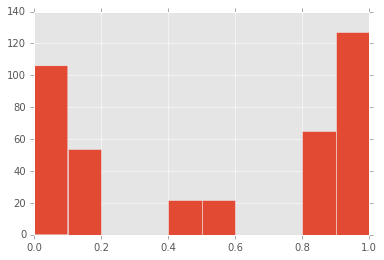

In [13]:
#make data tall
tall_df = labeled_prediction_df.transpose()
#Plot a histogram of error rate for each observation
matplotlib.style.use('ggplot')
plt.figure();
tall_df["ERROR_RATE"].hist()

Below, the tall dataframe can be exported to CSV.

In [ ]:
tall_csv_output = input() #name for csv output

In [ ]:
tall_df.to_csv(tall_csv_output) #call to create csv

Below, convert wide dataframe to CSV

In [ ]:
wide_csv_output = input() #name for csv output

In [ ]:
labeled_prediction_df.to_csv(wide_csv_output) #call to create csv

# Majority Choice Ensembler

The below code implements a majority choice ensembler.  This takes the labels of all of the experiments and determines which outcome was selected by a majority of the models for each observation-- a new vector is created that shows these results.  In general, this should improve the performance relative to most individual models, but this is not always the case.

In [14]:
#Calculate majority vote result for each observation and append to label dataframe.
ensemble_results_tmp = [1 if i > len(label_df)/2.0 else 0 for i in label_df.sum()]
ensemble_results = ["MAJORITY_ENSEMBLE"]
ensemble_results.extend(ensemble_results_tmp)
ensemble_df = pd.DataFrame(ensemble_results_tmp).transpose()
ensemble_df.columns = list(labeled_prediction_df)
ensemble_df.index = ["MAJORITY_ENSEMBLE"]
labeled_prediction_df=labeled_prediction_df.append(ensemble_df)
labeled_prediction_df

,C435_P27655,C507_P19252,C100_P7212,C413_P8768,C353_P20853,C201_P5308,C222_P14744,C72_P5716,C489_P29330,C201_P22308,...,C9_P468,C450_P11248,C453_P27686,C201_P5020,C513_P30100,C34_P24037,C140_P23585,C199_P22178,C315_P13301,C326_P21669
index,,,,,,,,,,,,,,,,,,,,,
BOW_APPEND_LOG_REG__20160913130940604000,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_DIFFERENCE_LOG_REG__20160913131216539000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
LOG_REG_BOW_PRODUCT__20160913131303756000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
LOG_REG_BOW_COS__20160913131348723000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_COS_LOG_REG__20160913162355825000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GROUND_TRUTH,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ERROR_RATE,0.0,1.0,0.6,0.4,0.6,1.0,0.2,0.2,0.2,1.0,...,0.2,0.4,0.2,1.0,1.0,1.0,0.2,1.0,1.0,1.0
MAJORITY_ENSEMBLE,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
#Calculate the results for the majority ensembler
majtall_df = labeled_prediction_df.transpose()
MAJORITY_ENSEMBLE = {}
MAJORITY_ENSEMBLE["rmse"] = sqrt(mean_squared_error(majtall_df["GROUND_TRUTH"], majtall_df["MAJORITY_ENSEMBLE"]))
MAJORITY_ENSEMBLE["mae"] = mean_absolute_error(majtall_df["GROUND_TRUTH"],majtall_df["MAJORITY_ENSEMBLE"])
MAJORITY_ENSEMBLE["accuracy"] = accuracy_score(majtall_df["GROUND_TRUTH"], majtall_df["MAJORITY_ENSEMBLE"])
prfs = precision_recall_fscore_support(majtall_df["GROUND_TRUTH"], majtall_df["MAJORITY_ENSEMBLE"])
MAJORITY_ENSEMBLE["precision_dup"] =  prfs[0][0]
MAJORITY_ENSEMBLE["precision_nov"] = prfs[0][1]
MAJORITY_ENSEMBLE["recall_dup"] = prfs[1][0]
MAJORITY_ENSEMBLE["recall_nov"] = prfs[1][1]
MAJORITY_ENSEMBLE["fscore_dup"] = prfs[2][0]
MAJORITY_ENSEMBLE["fscore_nov"] = prfs[2][1]
MAJORITY_ENSEMBLE["support_dup"] = prfs[3][0]
MAJORITY_ENSEMBLE["support_nov"] = prfs[3][1]
MAJORITY_ENSEMBLE["confusion_matrix"] = confusion_matrix(majtall_df["GROUND_TRUTH"], majtall_df["MAJORITY_ENSEMBLE"])
print("The rmse is " + str(MAJORITY_ENSEMBLE["rmse"]))
print("The mae is " + str(MAJORITY_ENSEMBLE["mae"]))
print("The accuracy is " + str(MAJORITY_ENSEMBLE["accuracy"]))
print("The precision (duplicate) is " + str(MAJORITY_ENSEMBLE["precision_dup"]))
print("The precision (novel) is " + str(MAJORITY_ENSEMBLE["precision_nov"]))
print("The recall (dup) is " + str(MAJORITY_ENSEMBLE["recall_dup"]))
print("The recall (nov) is " + str(MAJORITY_ENSEMBLE["recall_nov"] ))
print("The fscore (dup) is " + str(MAJORITY_ENSEMBLE["fscore_dup"]))
print("The fscore (nov) is " + str(MAJORITY_ENSEMBLE["fscore_nov"]))
print("The support (dup) is " + str(MAJORITY_ENSEMBLE["support_dup"] ))
print("The support (nov) is " + str(MAJORITY_ENSEMBLE["support_nov"]))
print("The confusion matrix is " + str(MAJORITY_ENSEMBLE["confusion_matrix"]))

The rmse is 0.735121786104
The mae is 0.540404040404
The accuracy is 0.459595959596
The precision (duplicate) is 0.0555555555556
The precision (novel) is 0.478835978836
The recall (dup) is 0.00505050505051
The recall (nov) is 0.914141414141
The fscore (dup) is 0.00925925925926
The fscore (nov) is 0.628472222222
The support (dup) is 198
The support (nov) is 198
The confusion matrix is [[  1 197]
 [ 17 181]]


In [16]:
#Add results of majority ensembler to dataframe of compiled results
majority_df = pd.DataFrame.from_dict(MAJORITY_ENSEMBLE, orient="index").transpose()
majority_df.index = ["MAJORITY_ENSEMBLE"]
allvalues_df = allvalues_df.append(majority_df)
allvalues_df

,BOW_APPEND,BOW_COS,BOW_DIFFERENCE,BOW_PRODUCT,BOW_TFIDF,CNN_APPEND,CNN_COS,CNN_DIFFERENCE,CNN_PRODUCT,EXPERIMENTDATAFILE,...,novelty,precision_dup,precision_nov,predicted_label,recall_dup,recall_nov,rmse,seed,support_dup,support_nov
index,,,,,,,,,,,,,,,,,,,,,
BOW_APPEND_LOG_REG__20160913130940604000,True,False,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.0857143,0.459834,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0.0151515,0.838384,0.757121,996141171.0,198,198
BOW_DIFFERENCE_LOG_REG__20160913131216539000,False,False,True,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.2,0.451613,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",0.0555556,0.777778,0.763763,330014090.0,198,198
LOG_REG_BOW_PRODUCT__20160913131303756000,False,False,False,True,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.495935,0.498168,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...",0.308081,0.686869,0.70889,12461061.0,198,198
LOG_REG_BOW_COS__20160913131348723000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.285714,0.496144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010101,0.974747,0.712444,27764409.0,198,198
BOW_COS_LOG_REG__20160913162355825000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.285714,0.496144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010101,0.974747,0.712444,477574113.0,198,198
MAJORITY_ENSEMBLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0555556,0.478836,NaN,0.00505051,0.914141,0.735122,NaN,198,198


# Correlation Ensemble
Take highest performing experiments and then find the most uncorrelated ones and ensembles them using the majority ensemble method.  By taking the least correlated models, and ensembling them, there is a better chance of improving results.  See http://mlwave.com/kaggle-ensembling-guide/.    

In [17]:
feature = input() # feature that you want to judge by.  Choices in clude fscore_nov, fscore_dup, rmse, mae, recall_nov,
                  # recall_dup, precision_nov, precision_dup

fscore_nov


In [21]:
value = input() # value for number of models to subset for top values; make sure it is less than the number of models

5


In [22]:
#Create dataframe that only has the "good" models

#good = allvalues_df[feature] > float(value)
if feature in ("precision_dup","precision_nov","recall_dup","recall_nov","fscore_nov","fscore_dup","accuracy"):
    allvalues_df = allvalues_df.sort_values(feature, ascending=False)
elif feature in ("rmse", "mae"):
    allvalues_df = allvalues_df.sort_values(feature)
    
subset_df = allvalues_df[0:int(value)]

good_df = labeled_prediction_df.ix[subset_df.index.values]
good_df = good_df[pd.notnull(good_df)]
good_df

,C435_P27655,C507_P19252,C100_P7212,C413_P8768,C353_P20853,C201_P5308,C222_P14744,C72_P5716,C489_P29330,C201_P22308,...,C9_P468,C450_P11248,C453_P27686,C201_P5020,C513_P30100,C34_P24037,C140_P23585,C199_P22178,C315_P13301,C326_P21669
index,,,,,,,,,,,,,,,,,,,,,
LOG_REG_BOW_COS__20160913131348723000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_COS_LOG_REG__20160913162355825000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
MAJORITY_ENSEMBLE,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_APPEND_LOG_REG__20160913130940604000,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
LOG_REG_BOW_PRODUCT__20160913131303756000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
#Create pearson correlation matrix


M = good_df.as_matrix()


correlation_matrix = np.array([[pearsonr(a,b)[0] for a in M] for b in M])

correlation_matrix

array([[ 1.        ,  1.        ,  0.15472777,  0.02574338, -0.09004207],
       [ 1.        ,  1.        ,  0.15472777,  0.02574338, -0.09004207],
       [ 0.15472777,  0.15472777,  1.        ,  0.65811597,  0.27270428],
       [ 0.02574338,  0.02574338,  0.65811597,  1.        ,  0.31008118],
       [-0.09004207, -0.09004207,  0.27270428,  0.31008118,  1.        ]])

In [24]:
size_of_ensemble = input() # how many models to ensemble.  An odd number is better as there won't be ties.

2


In [25]:
#This pics dissimilar experiments but is not doing the optimal strategy.  Instead, it takes the best model and finds the most dissimilar one and adds both to the list.  Then takes the next best and adds it and its most dissimilar to the list, and so forth.

ensemble_size = 0
row = 0
ensemble_indices = []
while ensemble_size < int(size_of_ensemble):
    if row not in ensemble_indices:
        ensemble_indices.append(row)
        ensemble_size += 1
        if ensemble_size == int(size_of_ensemble):
            break
        else:
            continue
        row_list = list(correlation_matrix[row])
        for i in range(0,row_list):
            ele = row_list.index(sorted(row_list)[i])
            if ele not in ensemble_indices:
                ensemble_indices.append(i)
                ensemble_size += 1
                break
        row += 1
    else:
        row += 1
        continue    
print(ensemble_indices)

[0, 1]


In [39]:
#Create dataframe that only has the selected models from the anti-correlation algorithm selects

ensemble_keys=[]
for i in ensemble_indices:
    ensemble_keys.append(good_df.index.values[i])
subset2_df = labeled_prediction_df.ix[ensemble_keys]


In [40]:
#Run majority ensemble on the correlation-selected models and add to the label dataframe
corrensemble_results_tmp = [1 if i > len(subset2_df)/2.0 else 0 for i in subset2_df.sum()]
corrensemble_results = ["CORR_ENSEMBLE"]
corrensemble_results.extend(corrensemble_results_tmp)
corrensemble_df = pd.DataFrame(corrensemble_results_tmp).transpose()
corrensemble_df.columns = list(labeled_prediction_df)
corrensemble_df.index = ["CORR_ENSEMBLE"]
labeled_prediction_df=labeled_prediction_df.append(corrensemble_df)
labeled_prediction_df

,C435_P27655,C507_P19252,C100_P7212,C413_P8768,C353_P20853,C201_P5308,C222_P14744,C72_P5716,C489_P29330,C201_P22308,...,C9_P468,C450_P11248,C453_P27686,C201_P5020,C513_P30100,C34_P24037,C140_P23585,C199_P22178,C315_P13301,C326_P21669
index,,,,,,,,,,,,,,,,,,,,,
BOW_APPEND_LOG_REG__20160913130940604000,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_DIFFERENCE_LOG_REG__20160913131216539000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
LOG_REG_BOW_PRODUCT__20160913131303756000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
LOG_REG_BOW_COS__20160913131348723000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BOW_COS_LOG_REG__20160913162355825000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GROUND_TRUTH,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ERROR_RATE,0.0,1.0,0.6,0.4,0.6,1.0,0.2,0.2,0.2,1.0,...,0.2,0.4,0.2,1.0,1.0,1.0,0.2,1.0,1.0,1.0
MAJORITY_ENSEMBLE,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CORR_ENSEMBLE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
csv_name_label_all = input() #name csv for label df with corr ensembler and majority ensembler

In [ ]:
labeled_prediction_df.to_csv(csv_name_label_all)

In [41]:
#Calculate metrics for correlation ensembling
corrtall_df = labeled_prediction_df.transpose()
corr_ensemble = {}
corr_ensemble["rmse"] = sqrt(mean_squared_error(corrtall_df["GROUND_TRUTH"], corrtall_df["CORR_ENSEMBLE"]))
corr_ensemble["mae"] = mean_absolute_error(corrtall_df["GROUND_TRUTH"],corrtall_df["CORR_ENSEMBLE"])
corr_ensemble["accuracy"] = accuracy_score(corrtall_df["GROUND_TRUTH"], corrtall_df["CORR_ENSEMBLE"])
prfs = precision_recall_fscore_support(corrtall_df["GROUND_TRUTH"], corrtall_df["CORR_ENSEMBLE"])
corr_ensemble["precision_dup"] =  prfs[0][0]
corr_ensemble["precision_nov"] = prfs[0][1]
corr_ensemble["recall_dup"] = prfs[1][0]
corr_ensemble["recall_nov"] = prfs[1][1]
corr_ensemble["fscore_dup"] = prfs[2][0]
corr_ensemble["fscore_nov"] = prfs[2][1]
corr_ensemble["support_dup"] = prfs[3][0]
corr_ensemble["support_nov"] = prfs[3][1]
corr_ensemble["confusion_matrix"] = confusion_matrix(corrtall_df["GROUND_TRUTH"], corrtall_df["CORR_ENSEMBLE"])
print("The rmse is " + str(corr_ensemble["rmse"]))
print("The mae is " + str(corr_ensemble["mae"]))
print("The accuracy is " + str(corr_ensemble["accuracy"]))
print("The confusion matrix is " + str(corr_ensemble["confusion_matrix"]))
print("The precision (duplicate) is " + str(corr_ensemble["precision_dup"]))
print("The precision (novel) is " + str(corr_ensemble["precision_nov"]))
print("The recall (dup) is " + str(corr_ensemble["recall_dup"]))
print("The recall (nov) is " + str(corr_ensemble["recall_nov"] ))
print("The fscore (dup) is " + str(corr_ensemble["fscore_dup"]))
print("The fscore (nov) is " + str(corr_ensemble["fscore_nov"]))
print("The support (dup) is " + str(corr_ensemble["support_dup"] ))
print("The support (nov) is " + str(corr_ensemble["support_nov"]))
#print("The confusion matrix is " + str(corr_ensemble["confusion_matrix"]))

The rmse is 0.712443511849
The mae is 0.507575757576
The accuracy is 0.492424242424
The confusion matrix is [[  2 196]
 [  5 193]]
The precision (duplicate) is 0.285714285714
The precision (novel) is 0.496143958869
The recall (dup) is 0.010101010101
The recall (nov) is 0.974747474747
The fscore (dup) is 0.019512195122
The fscore (nov) is 0.657580919932
The support (dup) is 198
The support (nov) is 198


In [43]:
#Add correlation ensembling to main data frame
corr_df = pd.DataFrame.from_dict(corr_ensemble, orient="index").transpose()
corr_df.index = ["CORR_ENSEMBLE"]
allvalues_df = allvalues_df.append(corr_df)
allvalues_df

,BOW_APPEND,BOW_COS,BOW_DIFFERENCE,BOW_PRODUCT,BOW_TFIDF,CNN_APPEND,CNN_COS,CNN_DIFFERENCE,CNN_PRODUCT,EXPERIMENTDATAFILE,...,novelty,precision_dup,precision_nov,predicted_label,recall_dup,recall_nov,rmse,seed,support_dup,support_nov
index,,,,,,,,,,,,,,,,,,,,,
LOG_REG_BOW_COS__20160913131348723000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.285714,0.496144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010101,0.974747,0.712444,27764409.0,198,198
BOW_COS_LOG_REG__20160913162355825000,False,True,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.285714,0.496144,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.010101,0.974747,0.712444,477574113.0,198,198
MAJORITY_ENSEMBLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0555556,0.478836,NaN,0.00505051,0.914141,0.735122,NaN,198,198
BOW_APPEND_LOG_REG__20160913130940604000,True,False,False,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.0857143,0.459834,"[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0.0151515,0.838384,0.757121,996141171.0,198,198
LOG_REG_BOW_PRODUCT__20160913131303756000,False,False,False,True,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.495935,0.498168,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, ...",0.308081,0.686869,0.70889,12461061.0,198,198
BOW_DIFFERENCE_LOG_REG__20160913131216539000,False,False,True,False,False,False,False,False,False,data/experimentdatafile.pkl,...,"[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",0.2,0.451613,"[1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...",0.0555556,0.777778,0.763763,330014090.0,198,198
CORR_ENSEMBLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.285714,0.496144,NaN,0.010101,0.974747,0.712444,NaN,198,198
CORR_ENSEMBLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.285714,0.496144,NaN,0.010101,0.974747,0.712444,NaN,198,198


In [ ]:
sort_value = input() # choose value to sort dataframe by

In [ ]:
last_df = allvalues_df.sort_values(sort_value)

In [ ]:
csv_name_all = input() #Name csv for output of main df with sorting and ensemblers

In [ ]:
last_df.to_csv(csv_name_all)